<a href="https://colab.research.google.com/github/alecbidaran/Chest-CTs-image-segmentation-with-UNET/blob/main/medical_segmentation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!pip install jupyter-dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 7.2 MB/s 
     |████████████████████████████████| 357 kB 67.8 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=41e9cf7c40e3da7c08f6ad569d1fdf3ff8cdf13c771310e453c9c8b108317592
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans
!unzip covid19-ct-scans.zip
!rm covid19-ct-scans.zip

 99% 1.02G/1.03G [00:05<00:00, 196MB/s]
100% 1.03G/1.03G [00:05<00:00, 206MB/s]
Archive:  covid19-ct-scans.zip
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_sca

In [ ]:
!pip install -q torch_snippets pytorch_model_summary

     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 235 kB 9.5 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 948 kB 71.2 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
import numpy as np
import pandas as pd
import nibabel as nib


In [ ]:
def read_ct(path):
  image=nib.load(path)
  array=image.get_fdata()
  array=np.rot90(np.array(array,dtype=np.float32))
  return array

In [ ]:
data=pd.read_csv("metadata.csv")
data

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
5,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
6,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
7,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
8,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
9,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [ ]:
CT_scans=Glob("ct_scans/")
Mask_scan=Glob("lung_and_infection_mask/")

(630, 630, 42)
(512, 512, 290)


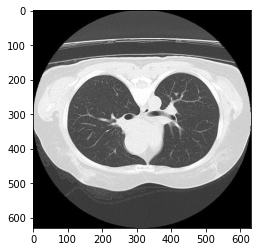

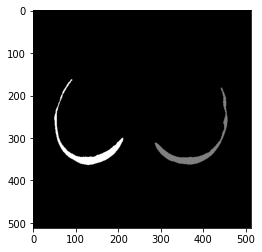

In [ ]:
img=read_ct(CT_scans[0])
mask=read_ct(Mask_scan[0])
print(img.shape)
print(mask.shape)
plt.imshow(img[...,25],cmap='gray')
plt.figure()
plt.imshow(mask[...,25],cmap='gray')

In [ ]:
CT = []
Mask = []
img_size =128




for case in range(len(data)): #Concat all cases to list
    ct = read_ct(CT_scans[case])
    mask = read_ct(Mask_scan[case])

    for imgsize in range(35):
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        mask_img = cv2.resize(mask[...,imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        CT.append(ct_img[np.newaxis,...])
        Mask.append(mask_img[np.newaxis,...])

In [ ]:
CT=np.array(CT)
Mask=np.array(Mask)
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

In [ ]:
class CT_dataset(Dataset):
    def __init__(self, CT,Mask):
        self.ct_scans =CT
        self.mask_scan = Mask

    def __len__(self):
        return len(self.ct_scans)

    def __getitem__(self, idx):
        ct=self.ct_scans[idx]
        masks=self.mask_scan[idx]
        return ct,masks
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([torch.tensor(im.copy()[None]) for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.tensor(mask[None]) for mask in masks]).float().to(device)
        return ims, ce_masks

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(norm_data,Mask,test_size=0.2,random_state=42)

In [ ]:
train_dataset=CT_dataset(x_train,y_train)
test_dataset=CT_dataset(x_test,y_test)

In [ ]:
train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True,collate_fn=train_dataset.collate_fn)
valid_dl=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False,collate_fn=test_dataset.collate_fn)


In [ ]:
img,label=next(iter(train_dl))
label.squeeze(1).shape

torch.Size([16, 128, 128])

(200, 1, 128, 128)
(200, 1, 128, 128)


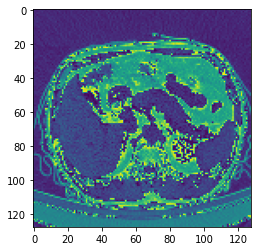

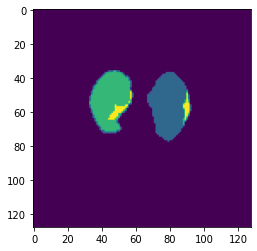

In [ ]:
image,label=train_dataset[:200]
print(image.shape)
print(label.shape)
plt.imshow(image[160].squeeze(0))
plt.figure()
plt.imshow(label[160].squeeze(0))

In [ ]:
len(train_dataset)

560

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3),padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def dilate_conv(in_channels, out_channels,dilation):
  return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=1,dilation=dilation),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
from torchvision.models import vgg16_bn
class tinyUNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=1):
        super().__init__()
        self.block1=conv(1,64)
        self.block2=conv(64,64)
        self.block3=conv(64,128)
        self.block4=conv(128,128)
        self.block5=conv(128,256)
        self.block6=conv(256,256)
        self.block7=conv(256,512)
        self.block8=conv(512,512)
        self.block9=conv(512,1024)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0,dilation=1,ceil_mode=False)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256+256,256)
        self.up_conv8 = up_conv(128+128, 128)
        self.conv8 = conv(128 + 128, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 +64, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1,padding="same")
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9=self.block9(block8)

        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4,block7],dim=1)
        x4=self.conv6(x4)
        x3 = self.up_conv7(x4)

        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        #x = self.up_conv10(x1)
        #x = torch.cat([x, block1], dim=1)
        #x = self.conv10(x)

        x =self.sigmoid(self.conv11(x1))

        return x

In [ ]:
def dice_coeff(preds,targets):
  smooth=1.
  preds=preds.flatten()
  targets=targets.flatten()
  intersection=(preds*targets).sum().float()
  dice=(2*intersection+smooth)/(preds.sum()+targets.sum()+smooth)
  return dice
ce = nn.BCELoss()
def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  dice=dice_coeff(preds,targets)
  dice_loss=1-dice
  loss=ce_loss+dice_loss
  acc=dice
  return loss, acc

#def UnetLoss(preds, targets):
 # ce_loss = ce(preds, targets)
  #loss=ce_loss
  #targets=targets.squeeze(1)
 # acc=(torch.max(preds,1)[1]==targets).float().mean()
 # return loss, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(preds=_masks, targets=ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(preds=_masks, targets=masks)
    return loss.item(), acc.item()

In [ ]:
model =tinyUNet().to(device)
criterion = UnetLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-6)
n_epochs = 5

In [ ]:
from torchsummary import summary
summary(model,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(valid_dl)
    for bx, data in enumerate(valid_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.247	trn_acc: 0.237	val_loss: 1.350	val_acc: 0.115	(6.91s - 27.63s remaining)
EPOCH: 2.000	trn_loss: 0.726	trn_acc: 0.327	val_loss: 1.091	val_acc: 0.201	(13.88s - 20.82s remaining)
EPOCH: 3.000	trn_loss: 0.465	trn_acc: 0.376	val_loss: 0.988	val_acc: 0.205	(20.91s - 13.94s remaining)
EPOCH: 4.000	trn_loss: 0.279	trn_acc: 0.415	val_loss: 1.001	val_acc: 0.208	(28.10s - 7.03s remaining)
EPOCH: 5.000	trn_loss: 0.094	trn_acc: 0.446	val_loss: 0.741	val_acc: 0.274	(35.37s - 0.00s remaining)


In [ ]:
PATH = "lung_infection_model.pt"
torch.save(model.state_dict(), PATH)


In [ ]:
valid_dl=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True,collate_fn=test_dataset.collate_fn)


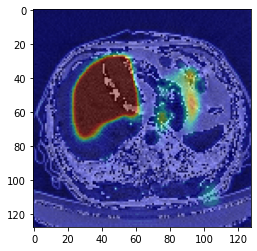

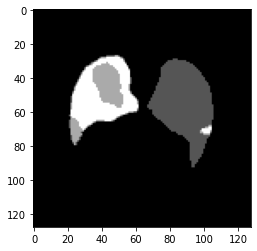

In [ ]:
img,mask=next(iter(valid_dl))
pimg=img[0].squeeze(0).detach().cpu().numpy()
_mask=model(img)
plt.imshow(pimg,cmap="gray")
plt.imshow(_mask[0].squeeze(0).cpu().detach().numpy(),cmap="jet",alpha=0.4)
plt.figure()

plt.imshow(mask[0].squeeze(0).cpu().detach().numpy(),cmap="gray")



In [ ]:
!pip install dash-bootstrap-components
!pip install dash-daq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 31.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 642 kB 32.2 MB/s 
  Created wheel for dash-daq: filename=dash_daq-0.5.0-py3-none-any.whl size=669714 sha256=857b960d1519e00437d2ecdd397c0160a5c25bf1d99893fa6a715f44023ce870
  Stored in directory: /root/.cache/pip/wheels/fe/54/53/a8d448db5592874db4313240571ca2c069e55f6a6b29bf5847
Successfully built dash-daq


In [ ]:
!pip install dash-canvas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 737 kB 27.4 MB/s 
  Created wheel for dash-canvas: filename=dash_canvas-0.1.0-py3-none-any.whl size=745346 sha256=05fad919ccfe29868996200635c4a2ea1a167e92319cea344d1aaf1eec42e708
  Stored in directory: /root/.cache/pip/wheels/82/4d/c5/f0cec1a0ce8d7930976eccca658a39c9e3a3c62867ff575f09
Successfully built dash-canvas


In [ ]:
import cv2
import numpy as np
from jupyter_dash import JupyterDash
from dash import dcc,html
import dash
from dash_canvas import DashCanvas
from dash_canvas.utils import array_to_data_url,parse_jsonstring
import dash_daq
import dash_bootstrap_components as dbc
import plotly.express as px


In [ ]:
PATH = "state_dict_model.pt"
model = tinyUNet().to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

tinyUNet(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

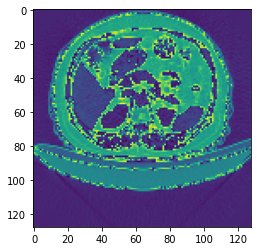

In [ ]:
valid_dl=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True,collate_fn=test_dataset.collate_fn)
img,mask=next(iter(valid_dl))
pimg=img[0].squeeze(0).detach().cpu().numpy()
plt.imshow(pimg)

In [ ]:
def predict(img):
  _mask=model(img)
  return _mask

(128, 128, 3)


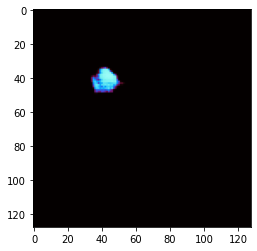

In [ ]:
mask=predict(img)
mask=(255*mask[0].squeeze(0).cpu().detach().numpy()).astype(np.uint8)
mask=cv2.applyColorMap(mask,cv2.COLORMAP_INFERNO)

plt.imshow(mask)
print(mask.shape)

In [ ]:
def threshold_image(img,min_value,max_value):
    ret,thresh=cv2.threshold(img,min_value,max_value,cv2.THRESH_OTSU)
    return thresh

In [ ]:
app=JupyterDash(__name__,external_stylesheets=[dbc.themes.DARKLY])

In [ ]:
from torch._C import Graph

SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "25rem",
    "padding": "2rem 1rem",
}
CONTENT_STYLE = {
    "margin-left": "30rem",
    "margin-right": "10rem",
    "padding": "2rem 1rem",
}
app.layout=html.Div([

    html.H4("Brain cancer detection Image system"),
    html.Div([
    html.Img(src=array_to_data_url((255*pimg).astype(np.uint8)),width=300),
    html.Img(id="predicted_segmented",width=300),


    ],style=CONTENT_STYLE
),

    html.Div([
        html.Button("Segment",id="pred_button"),
             ],
             style=SIDEBAR_STYLE)])

@app.callback(dash.Output("predicted_segmented","src"),
              dash.Input("pred_button","n_clicks"))
def show_pred(n_clicks):
    if n_clicks is not None:
        #mask=predict(img)
        #mask=(255*mask[0].squeeze(0).cpu().detach().numpy()).astype(np.uint8)
        #mask=cv2.applyColorMap(mask,cv2.COLORMAP_INFERNO)
        pimg=(255*pimg).astype(np.uint8)
        #pimg=cv2.cvtColor(pimg,cv2.COLOR_GRAY2RGB)
        #segmented=cv2.addWeighted(pimg,0.8,mask,0.2,0)
        return array_to_data_url(pimg)





In [ ]:
app.run_server(mode="external",port=8881,debug=True)

Dash app running on:


<IPython.core.display.Javascript object>